<a href="https://colab.research.google.com/github/DannyData1419/supervised-ML/blob/main/Binary_Classification_with_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification with Class

##Import libraries

In [1]:
!pip -q install lime
!pip -q install shap
!pip -q install discern-xai==0.0.23 # required pip install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.2 MB/s eta 0:00:00


In [42]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import shap
import xgboost
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier as MLP
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from discern.discern_tabular import DisCERNTabular

# when using MLP classifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


##Class and functions

* class `BinaryClassificationForTab:`
  * def `clasif_report_and_conf_matrix(...)`
  * def `print_classification_report(...)`
  * def `plot_confusion_matrix(...)`
  * def `plot_roc_curve(...)`

In [193]:
# VERSION 2
class BinaryClassificationForTab:

    def __init__(self, x, y, classifier, label_mapping, model_desc, data_desc, experiment_num):
        """
        Initializes the evaluator with features & target, classification model, label mapping, model type, data description, and experiment number.
        """
        self.x = x                                # features
        self.y = y                                # target
        self.data_desc = data_desc                # data description (global)
        self.label_mapping = label_mapping        # feature label mapping (global)
        self.model_desc = model_desc              # model description (local)
        self.classifier = classifier              # classification model (local)
        self.experiment_num = experiment_num      # experiment number (local)
        self.clasif_report = None                 # to store classification report
        self.confusn_matrix = None                # to store confusion matrix
        self.mean_auc = None                      # to store mean AUC value
        self.estimator_num = None                 # to store estimator number


    def print_confusion_matrix(self):
        """
        Generates a confusion matrix using 5-fold cross-validation
        """
        kf = StratifiedKFold(n_splits=5)
        confusn_matrices = []

        for train_index, test_index in kf.split(self.x, self.y):
            x_train, x_test = self.x.iloc[train_index], self.x.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            self.classifier.fit(x_train, y_train)
            predictions = self.classifier.predict(x_test)

            y_test_text = [self.label_mapping[label] for label in y_test]
            pred_text = [self.label_mapping[label] for label in predictions]

            confusn_matrix_fold = confusion_matrix(y_test_text, pred_text, labels=list(self.label_mapping.values()))

            confusn_matrices.append(confusn_matrix_fold)

        self.confusn_matrix = np.mean(confusn_matrices, axis=0)

        display = metrics.ConfusionMatrixDisplay(self.confusn_matrix, display_labels=list(self.label_mapping.values()))
        display.plot()
        plt.xticks(rotation=90)
        plt.title(f'{self.model_desc} on {self.data_desc} experiment #{self.experiment_num}')
        plt.show()


    def print_classification_report(self):
        """
        Generates a classification report without 5-fold cross-validation
        """
        # Split the data once into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=42)

        # Fit the classifier and make predictions
        self.classifier.fit(x_train, y_train)
        predictions = self.classifier.predict(x_test)

        # Map labels to their corresponding text representations
        y_test_text = [self.label_mapping[label] for label in y_test]
        pred_text = [self.label_mapping[label] for label in predictions]

        # Generate classification report
        self.clasif_report = classification_report(y_test_text, pred_text, output_dict=False)

        # Print the results
        print(f'{self.model_desc} on {self.data_desc} experiment #{self.experiment_num}:\n')
        print(self.clasif_report)


    def plot_roc_curve(self):
        """
        Displays a Receiver Operating Characteristic curve plot for an ML experiment
        """
        kf = StratifiedKFold(n_splits=5)
        tprs = []
        aucs = []
        mean_false_pos_rate = np.linspace(0, 1, 100)

        for train, test in kf.split(self.x, self.y):
            x_train, x_test, y_train, y_test = self.x.iloc[train], self.x.iloc[test], self.y[train], self.y[test]
            self.classifier.fit(x_train, y_train)
            probas_ = self.classifier.predict_proba(x_test)
            false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probas_[:, 1], pos_label=list(self.label_mapping.keys())[1])
            roc_auc = auc(false_pos_rate, true_pos_rate)
            aucs.append(roc_auc)
            tprs.append(np.interp(mean_false_pos_rate, false_pos_rate, true_pos_rate))
            tprs[-1][0] = 0.0

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        self.mean_auc = auc(mean_false_pos_rate, mean_tpr)

        # Plot the ROC curve
        plt.figure(figsize=(6, 4))
        plt.plot(mean_false_pos_rate, mean_tpr, color='b', label=f'Mean ROC (AUC = {self.mean_auc:.3f})', lw=2, alpha=0.8)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8) # diagonal line for no-skill classifier
        plt.xlim([-0.02, 1.02])             # set limits for axes
        plt.ylim([-0.02, 1.02])
        plt.xlabel('False Positive Rate')   # set labels and title
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_desc} on {self.data_desc} experiment #{self.experiment_num}')
        plt.legend(loc="lower right")       # add legend inside plot
        plt.show()                          # display plot


    def plot_feature_importance(self):
      """
      Plots a feature importance plot for a classification model
      """
      feature_imp = pd.Series(self.classifier.feature_importances_, index=self.x.columns.tolist()).sort_values(ascending=False)
      sns.barplot(x=feature_imp, y=feature_imp.index)
      plt.xlabel('Feature importance score')
      plt.ylabel('Feature name')
      plt.title(f"{self.model_desc} on {self.data_desc} feature importances, experiment #{self.experiment_num}", pad=10, size=12)
      plt.show()


    def plot_decision_tree(self):
      """
      Plots a single decision tree
      """
      plt.figure(figsize=(30, 12))
      plot_tree(self.classifier, feature_names=self.x.columns.tolist(), filled=True)
      plt.title(f"{self.model_desc} on {self.data_desc} plot, experiment #{self.experiment_num}", pad=10, size=12)
      plt.show()


    def plot_single_rf_tree(self):
      """
      Plots a single decision tree from a Random Forest ensemble
      """
      self.estimator_num = random.randint(0, len(self.classifier.estimators_)) # select a random decision tree model
      fig = plt.figure(figsize=(30, 12))
      plot_tree(self.classifier.estimators_[self.estimator_num],
                feature_names=self.x.columns.tolist(),
                class_names=self.label_mapping,
                filled=True,
                impurity=True,
                rounded=True)
      plt.title(f'{self.model_desc} on {self.data_desc} plot, experiment #{self.experiment_num}\nDecision tree #{self.estimator_num} of {len(self.classifier.estimators_)} Random Forest ensemble',
                pad=10, size=12)
      plt.show()


    # SHAP for global feature explainability
    def print_shap_tree_explainer(self):
      """
      The shap_tree_explainer function is a comprehensive tool for training an XGBoost model on survival
      data and visualizing the feature importance using SHAP values. It handles data splitting, model
      training, and result interpretation in a single, cohesive workflow.
      """
      # model parameters
      params = {
        "eta": 0.002,                # learning rate, controls step size at each iteration
        "max_depth": 3,              # max tree depthin model
        "objective": "survival:cox", # specifies the type of model to be trained, here it's "survival," which is suitable for survival analysis
        "subsample": 0.5             # fraction of the training data to be used for training each tree
        }

      # data prep
      xgb_full = xgboost.DMatrix(self.x, label=self.y)                # converts feature matrix 'x' and labels 'y' into a DMatrix, a data structure optimized for XGBoost
      x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=8) # 80/20 train/test split
      xgb_train = xgboost.DMatrix(x_train, label=y_train)   # training set converted into DMatrix format for XGBoost
      xgb_test = xgboost.DMatrix(x_test, label=y_test)      # testing set converted into DMatrix format for XGBoost

      # train model
      model = xgboost.train(params, xgb_train,              # trains the XGBoost model with the specified parameters
                            10000,                          # the number of boosting rounds or iterations
                            evals = [(xgb_test, "test")],   # list containing the testing set, used for evaluating model performance during training
                            verbose_eval=False)             # set to False to suppress verbose output during training

      # SHAP values calc
      # shap.TreeExplainer: creates an explainer object that can calculate SHAP values for tree-based models
      # shap_values: these values represent the contribution of each feature to the model's predictions, calculated for the entire dataset 'x'
      shap_values = shap.TreeExplainer(model).shap_values(self.x)

      # shap.summary_plot: generates summary plot that visualizes SHAP values, showing impact of each feature on model output, sorted by importance
      plt.title(f'XGBoost on {self.data_desc} for global feature importance')
      shap_summary_plot = shap.summary_plot(shap_values, self.x)
      return shap_summary_plot


###SHAP Tree Explainer Function


###LIME explainer Function

In [5]:
def lime_tab_for_classification(x, y, classifier, label_mapping, idx):
  warnings.filterwarnings("ignore", category=FutureWarning) # suppress specific warnings related to future deprecations
  warnings.filterwarnings("ignore", category=UserWarning)   # suppress specific warnings related to future deprecations

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8) # 80/20 train/test split

  classifier.fit(x_train, y_train)

  explainer_lime = lime_tabular.LimeTabularExplainer(       # create a lime tab explainer instance
      x_train.values,                                       # train data values
      feature_names=x.columns.tolist(),                     # create feature name list
      class_names=list(label_mapping.values()),             # class label mapping
      verbose=True,                                         # print local prediction values from linear model
      mode='classification')                                # classification task (and not regression)

  print(f'Observation #{x_test.index[idx]}, from a total of {len(x_test)} of {data_desc}, for local feature importance:')

  exp = explainer_lime.explain_instance(x_test.iloc[idx],            # explain test data instance
                                        classifier.predict_proba,    # predict probabilities using classifier
                                        num_features=10)             # limit to top 10 features

  return exp.show_in_notebook(show_table=True, show_all=False)       # display notebook and table

##Import data + prep

In [6]:
# load binary dataset for classification
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

###Dataframe info

In [7]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

###Split data into features and target

In [8]:
x = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

###Set GLOBAL variables

In [9]:
# set GLOBAL variables
data_desc = 'breast cancer data'
label_mapping = {0:'malignant', 1:'benign'}

#Experiments

##Experiment #1 Decision Tree

In [194]:
# set LOCAL variables per experiment
experiment_num = '1'
model_desc = 'Decision Tree'
classifier = DecisionTreeClassifier(random_state=8)

# run class and functions using global and local vars
evaluator = BinaryClassificationForTab(x, y, classifier, label_mapping, model_desc, data_desc, experiment_num)

###Classification report

In [172]:
evaluator.print_classification_report()

Decision Tree on breast cancer data experiment #1:

              precision    recall  f1-score   support

      benign       0.94      0.94      0.94        71
   malignant       0.91      0.91      0.91        43

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



* **Precision**: The precision for each class is the ratio of true positives (correctly predicted instances) to the sum of true positives and false positives (instances incorrectly predicted as positive). It measures the  accuracy of positive predictions. Precision is reported for each class.

* **Recall**: The recall, also known as sensitivity or true positive rate, for each class is the ratio of true positives to the sum of true positives and false negatives (instances incorrectly predicted as negative). It measures the model's ability to correctly identify positive instances. Recall is reported for each class.

* **F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. The F1-score is reported for each class. The closer it is to 1, the better the model.

* **Support**: The support indicates the number of occurrences of each class in the true labels. It represents the number of samples belonging to each class.

* **Accuracy**: The accuracy is the proportion of correctly classified instances (both true positives and true negatives) to the total number of instances. It provides an overall measure of the model's performance.

* **Macro average**: The macro average is the average of precision, recall, and F1-score across all classes. It treats all classes equally, regardless of class imbalance.

* **Weighted average**: The weighted average is the average of precision, recall, and F1-score across all classes, weighted by the support (number of samples) of each class. It considers the class imbalance and provides a more representative evaluation metric.

* [https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python](https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python)

###Confusion matrix

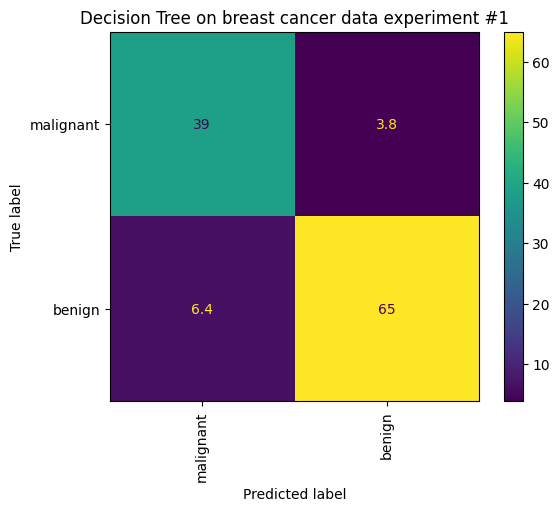

In [174]:
evaluator.print_confusion_matrix()

###Receiver Operating Characteristic curve

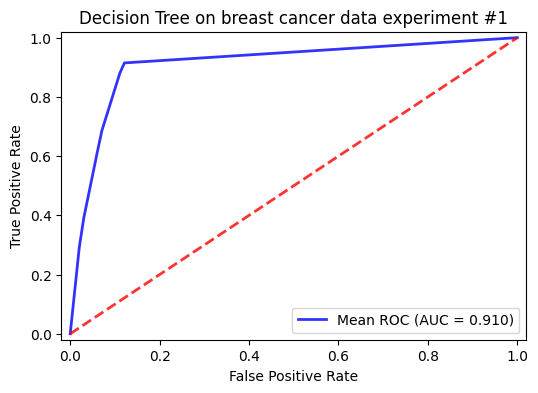

In [175]:
evaluator.plot_roc_curve()

###Feature importance

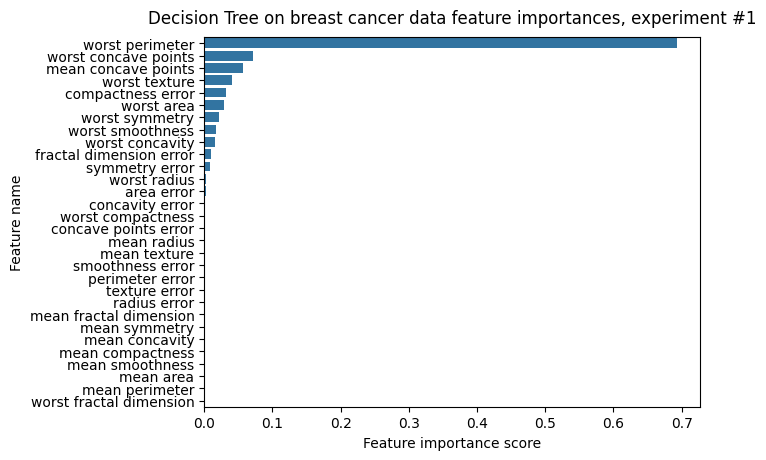

In [176]:
evaluator.plot_feature_importance()

###Decision Tree

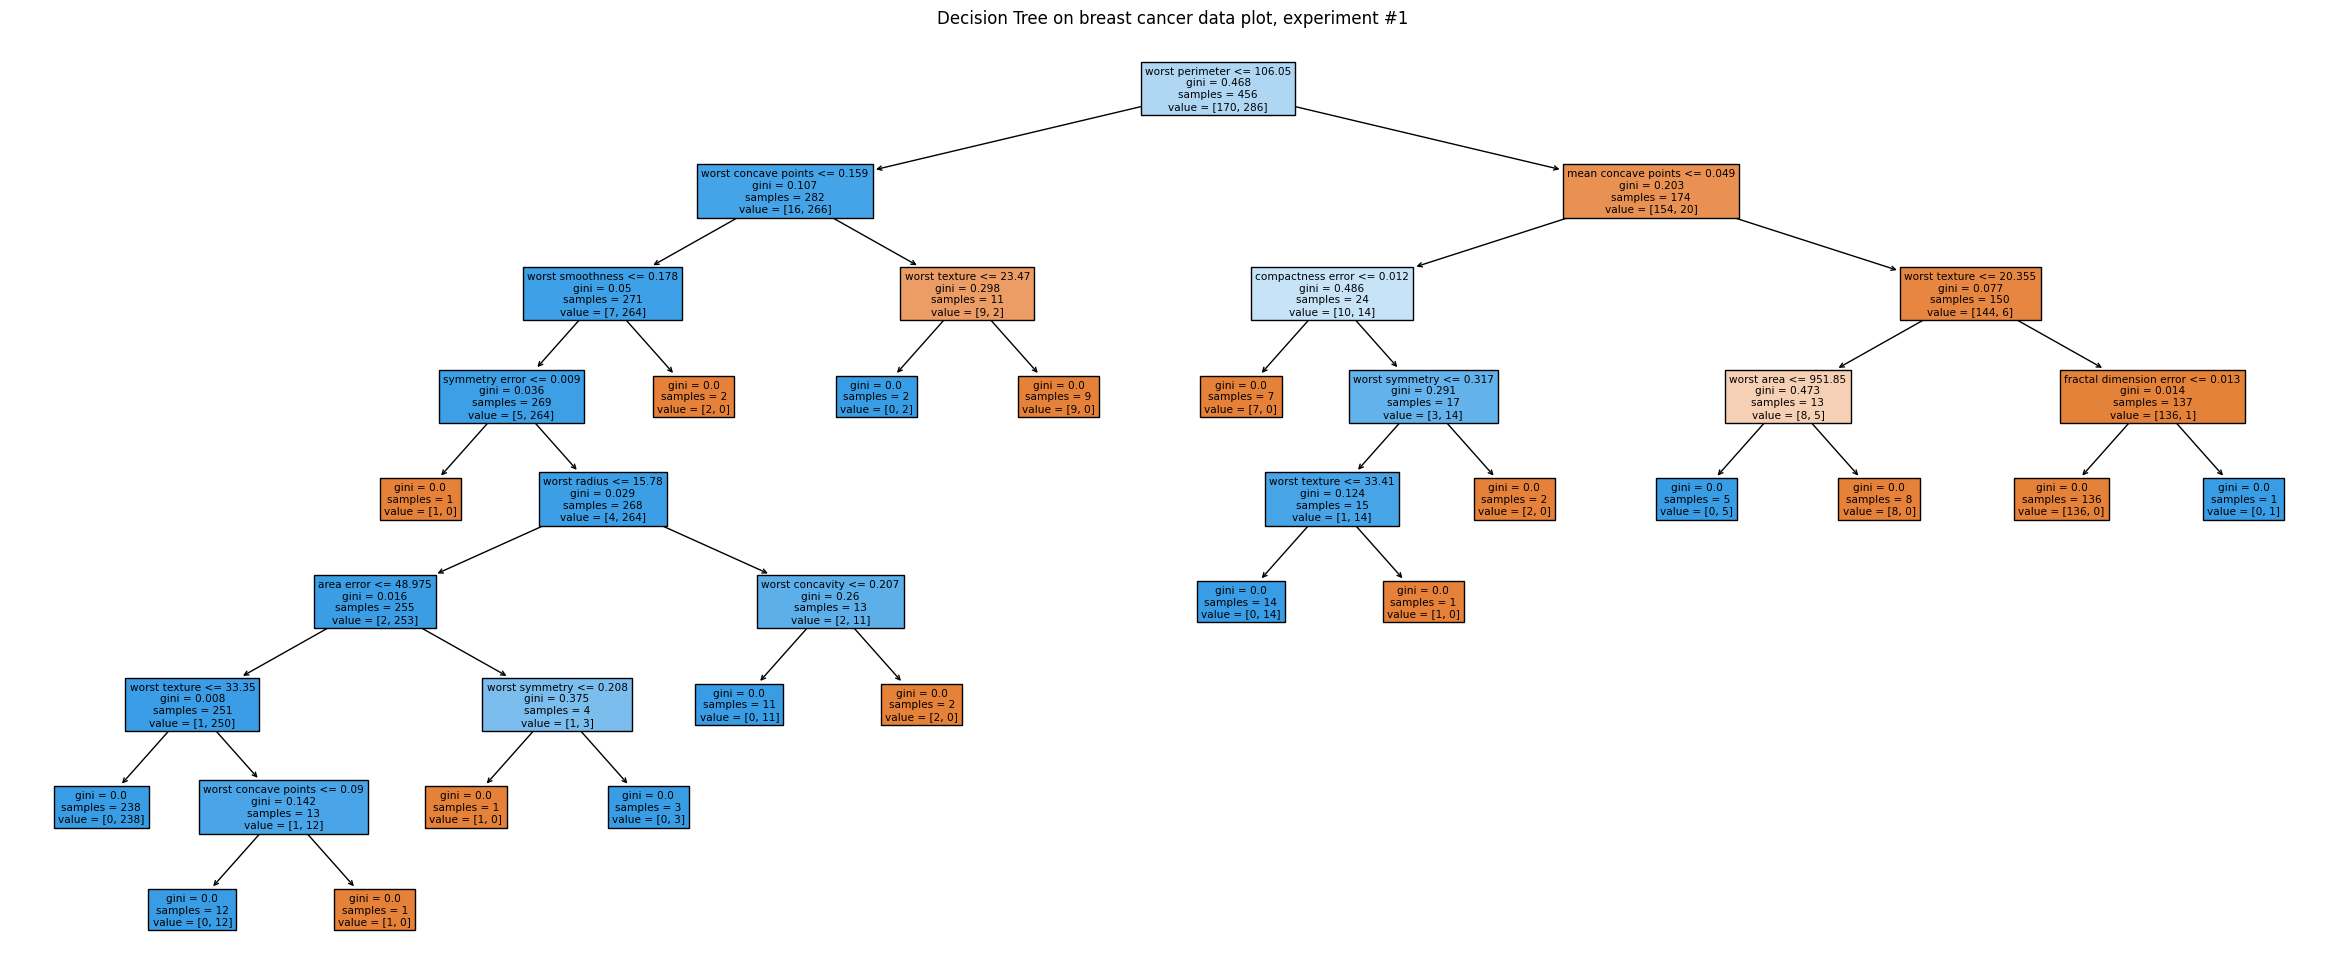

In [177]:
evaluator.plot_decision_tree()

##Experiment #2 Random Forest

In [197]:
# set LOCAL variables per experiment
experiment_num = '2'
model_desc = 'Random Forest'
classifier = RandomForestClassifier(random_state=8, n_estimators=500)

# run class and functions using global and local vars
evaluator = BinaryClassificationForTab(x, y, classifier, label_mapping, model_desc, data_desc, experiment_num)

###Classification report

In [198]:
evaluator.print_classification_report()

Random Forest on breast cancer data experiment #2:

              precision    recall  f1-score   support

      benign       0.96      0.99      0.97        71
   malignant       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



* **Precision**: The precision for each class is the ratio of true positives (correctly predicted instances) to the sum of true positives and false positives (instances incorrectly predicted as positive). It measures the  accuracy of positive predictions. Precision is reported for each class.

* **Recall**: The recall, also known as sensitivity or true positive rate, for each class is the ratio of true positives to the sum of true positives and false negatives (instances incorrectly predicted as negative). It measures the model's ability to correctly identify positive instances. Recall is reported for each class.

* **F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. The F1-score is reported for each class. The closer it is to 1, the better the model.

* **Support**: The support indicates the number of occurrences of each class in the true labels. It represents the number of samples belonging to each class.

* **Accuracy**: The accuracy is the proportion of correctly classified instances (both true positives and true negatives) to the total number of instances. It provides an overall measure of the model's performance.

* **Macro average**: The macro average is the average of precision, recall, and F1-score across all classes. It treats all classes equally, regardless of class imbalance.

* **Weighted average**: The weighted average is the average of precision, recall, and F1-score across all classes, weighted by the support (number of samples) of each class. It considers the class imbalance and provides a more representative evaluation metric.

* [https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python](https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python)

###Confusion matrix

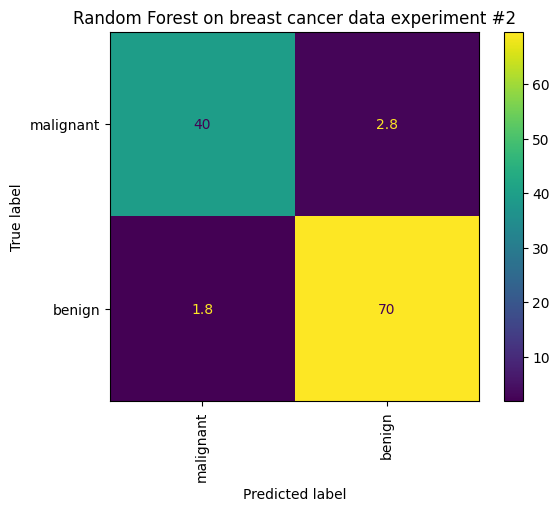

In [199]:
evaluator.print_confusion_matrix()

###Receiver Operating Characteristic curve

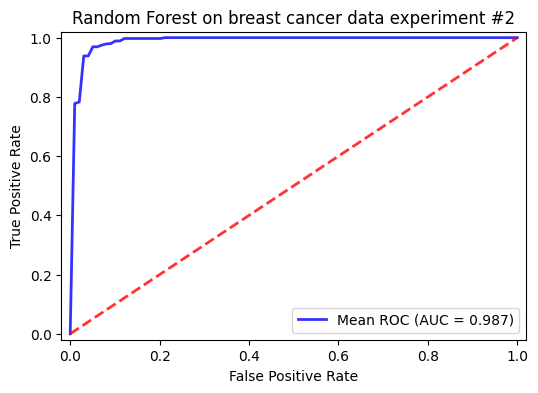

In [200]:
evaluator.plot_roc_curve()

###Feature importance

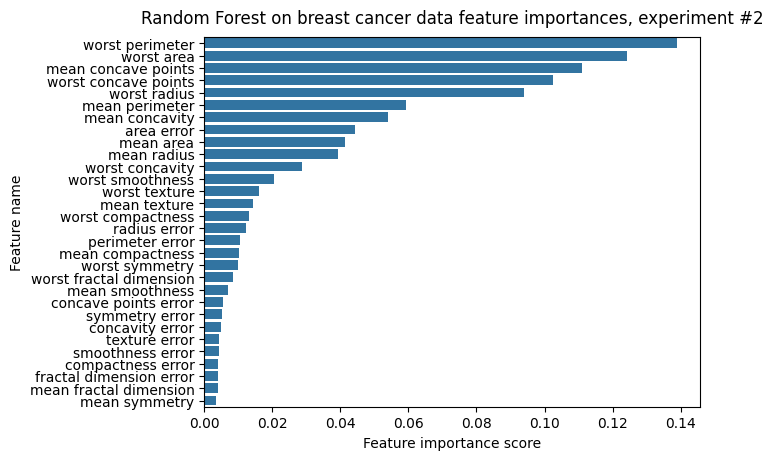

In [201]:
evaluator.plot_feature_importance()

###Plot Decision Tree from Random Forest ensemble

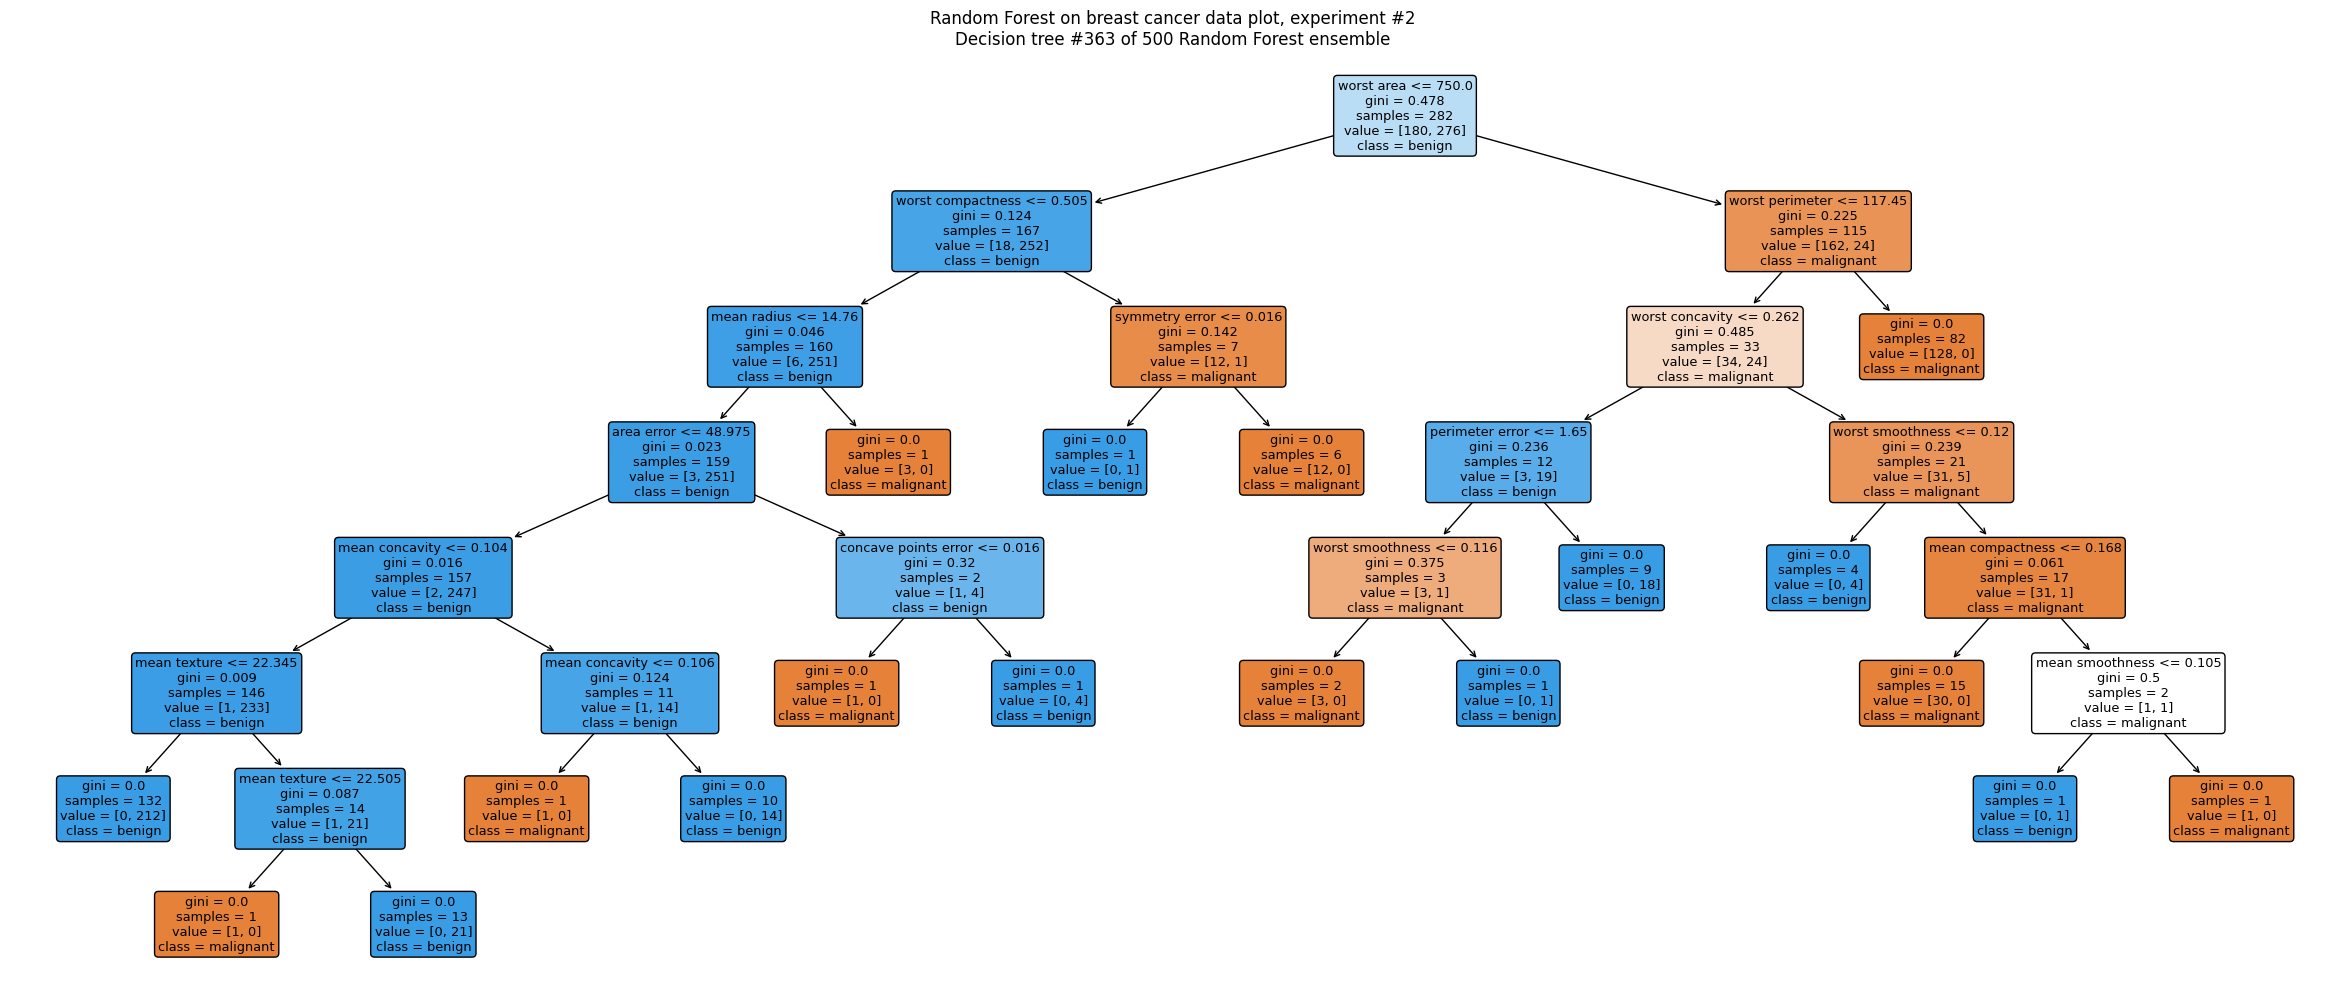

In [203]:
evaluator.plot_single_rf_tree()

##Experiment #3 Multi Layer Perceptron

In [204]:
# set LOCAL variables per experiment
experiment_num = '3'
model_desc = 'MLP'
classifier = MLP(random_state=8, max_iter=300)

# run class and functions using global and local vars
evaluator = BinaryClassificationForTab(x, y, classifier, label_mapping, model_desc, data_desc, experiment_num)

###Classification report

In [205]:
evaluator.print_classification_report()

MLP on breast cancer data experiment #3:

              precision    recall  f1-score   support

      benign       0.97      0.97      0.97        71
   malignant       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



* **Precision**: The precision for each class is the ratio of true positives (correctly predicted instances) to the sum of true positives and false positives (instances incorrectly predicted as positive). It measures the  accuracy of positive predictions. Precision is reported for each class.

* **Recall**: The recall, also known as sensitivity or true positive rate, for each class is the ratio of true positives to the sum of true positives and false negatives (instances incorrectly predicted as negative). It measures the model's ability to correctly identify positive instances. Recall is reported for each class.

* **F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. The F1-score is reported for each class. The closer it is to 1, the better the model.

* **Support**: The support indicates the number of occurrences of each class in the true labels. It represents the number of samples belonging to each class.

* **Accuracy**: The accuracy is the proportion of correctly classified instances (both true positives and true negatives) to the total number of instances. It provides an overall measure of the model's performance.

* **Macro average**: The macro average is the average of precision, recall, and F1-score across all classes. It treats all classes equally, regardless of class imbalance.

* **Weighted average**: The weighted average is the average of precision, recall, and F1-score across all classes, weighted by the support (number of samples) of each class. It considers the class imbalance and provides a more representative evaluation metric.

* [https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python](https://www.shedloadofcode.com/blog/understanding-explainable-ai-for-classification-regression-and-clustering-with-python)

###Confusion matrix

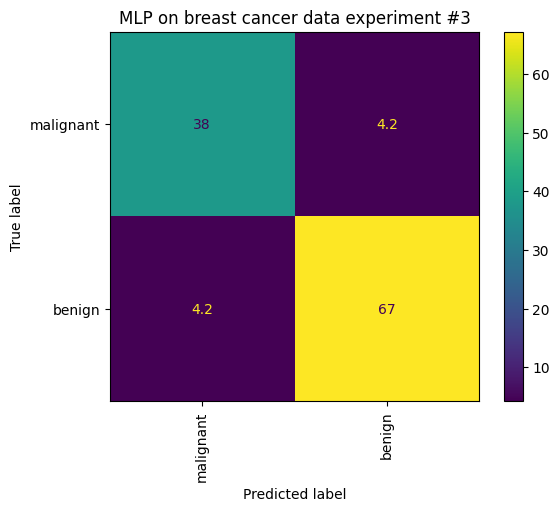

In [207]:
evaluator.print_confusion_matrix()

###Receiver Operating Characteristic curve

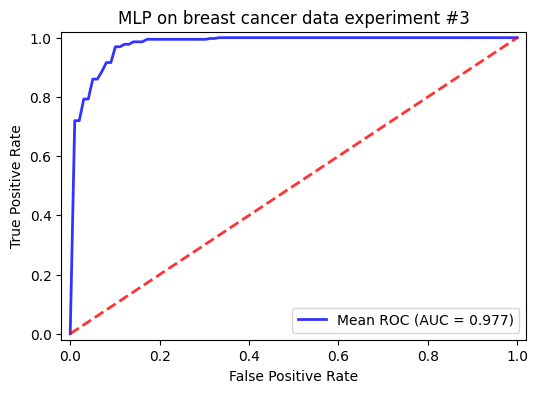

In [208]:
evaluator.plot_roc_curve()

#Global explainability

####SHAP (**SH**apley **A**dditive ex**P**lanations)
Explanation of SHAP and game theory
Expolanation of XGBoost
* [Medium: XGBoost Explained: A Beginner’s Guide](https://medium.com/low-code-for-advanced-data-science/xgboost-explained-a-beginners-guide-095464ad418f)
* https://github.com/shap/shap?tab=readme-ov-file#sample-notebooks
* https://shap.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html
* [Github repo](https://github.com/shap/shap)

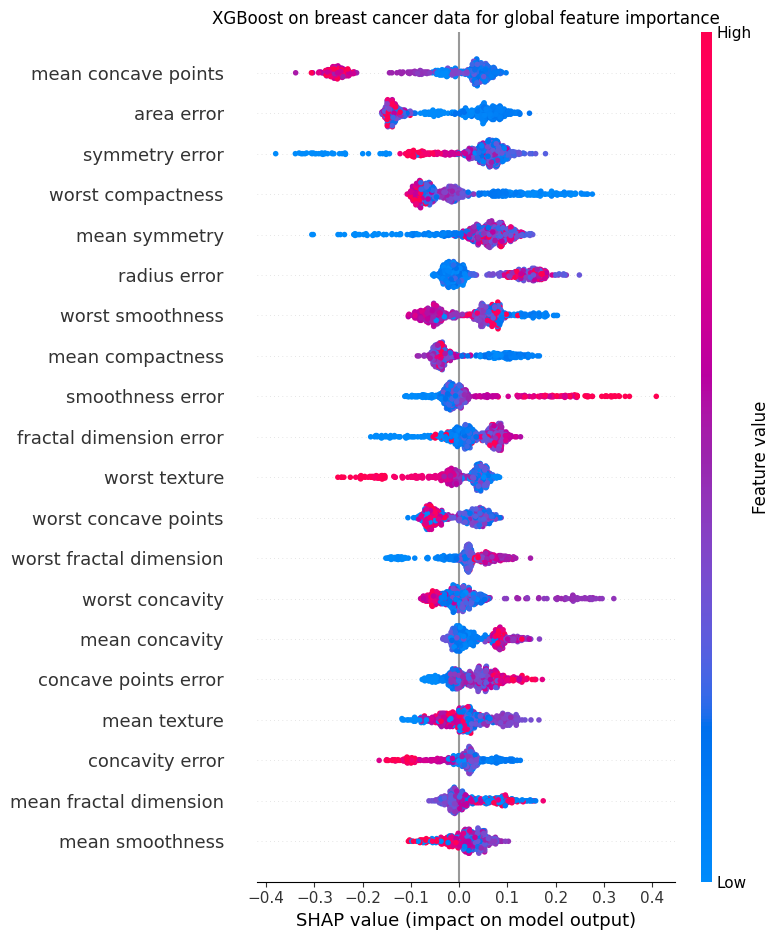

In [195]:
evaluator.print_shap_tree_explainer()

#Local explainability

In [ ]:
# view observation
model_desc = 'Random Forest'
classifier = RandomForestClassifier(random_state=8)

idx = 70
lime_tab_for_classification(x, y, classifier, label_mapping, idx)

From a total of 114 test data, observation #119 of breast cancer data for local feature importance:
Intercept 0.7398486528800959
Prediction_local [0.17993814]
Right: 0.1


####LIME (**L**ocal **I**nterpretable **M**odel-Agnostic **E**xplanations)
* [LIME documentation](https://lime-ml.readthedocs.io/en/latest/index.html)
* **Intercept**: is the base prediction of the linear model that LIME fits locally around the instance. In other words, it is the predicted probability for the instance before considering the effects of any features. This value represents the starting point (or bias) in the linear approximation model. LIME creates a simple linear model that approximates the complex classifier’s behavior in the neighborhood of the instance being explained. The intercept is the value when all feature effects are set to zero.
* **Prediction local**: is the probability predicted by the linear model (the surrogate model) that LIME has generated for this specific instance.
In this case, the LIME model predicts a probability of 0.61973125 for the positive class (or the class of interest).
This value results from adding the contributions of the features to the intercept.
* **Right**: refers to the actual probability predicted by your original classifier (the one you trained) for the instance being explained.
In this case, your classifier predicts a probability of 0.9936492970816642 for the positive class.
This indicates that the classifier is very confident about its prediction for this instance.